In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [9]:
BATCH_SIZE = 512

In [10]:
data = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_training_set.csv"
)
data = data.drop(columns=["respondent_id"])

training_dataset = np.array(data, dtype=np.float64)

# 切分数据为 Batch
def load_data(data: np.ndarray, batch_size, shuffle=True):
    data = data[: (data.shape[0] // batch_size) * batch_size]
    # print(data.shape[0] // batch_size)
    if shuffle:
        print("Shuffling data")
        np.random.shuffle(data)
    for i in range(batch_size, data.shape[0] + 1, batch_size):
        yield data[i - batch_size : i, :-2], data[i - batch_size : i, -2:]

In [11]:
from typing import Any


# Activation Function
def sigmoid(x) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


class Model:
    def __init__(self, in_feature, out_feature=1) -> None:
        self.weights = np.zeros((in_feature, out_feature))

    def __call__(self, *args: Any, **kwds: Any):
        return self.forward(*args, **kwds)

    def forward(self, x: np.ndarray) -> np.ndarray:
        x = np.dot(x, self.weights)
        x = sigmoid(x)
        return x

    def gradient(self, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:
        grad = self.forward(data_x)
        grad = grad - data_y
        grad = np.dot(data_x.T, grad)
        grad /= len(data_x)
        return grad


# Loss Function
def Loss(y_pred: np.ndarray, y_data: np.ndarray):
    tru = y_data * np.log(y_pred)
    fla = (1 - y_data) * np.log(1 - y_pred)
    return -np.mean(tru + fla)


def draw_loss(train_loss):
    plt.plot(
        np.arange(len(train_loss)),
        train_loss,
        color=np.random.rand(
            3,
        ),
        label="train loss",
    )
    plt.legend(loc=0, ncol=1)
    plt.xlabel("iternations")
    plt.ylabel("loss")
    # plt.show()


# Calculate Accuracy
def accuracy(real_val, predict_val):
    assert len(real_val) == len(predict_val)
    correct = [1 if x == y else 0 for (x, y) in zip(real_val, predict_val)]
    return np.sum(correct) / len(real_val)

#### 全批量梯度下降

对全体数据集有较好的训练效果，但是计算量大，速度慢，不适合大数据集。

In [12]:
def train_BGD(model: Model, data, threshold, lr=0.5):
    train_loss = []
    for epoch in range(0, threshold):
        grad = np.zeros(model.weights.shape)
        loss = 0
        for id, (x, y) in enumerate(load_data(data, BATCH_SIZE, shuffle=True)):
            y_pred = model(x)
            grad += model.gradient(x, y)
            loss += Loss(y_pred, y)
        grad /= len(data) // BATCH_SIZE
        loss /= len(data) // BATCH_SIZE
        print(f"epoch: {epoch}, loss: {loss}")
        model.weights = model.weights - lr * grad
        train_loss.append(loss)

    # loss curve
    draw_loss(train_loss)

#### 小批量随机梯度下降

计算量被切分，便于计算，但是单次下降并不一定朝着全局最优解的方向，可能会在局部最优解附近震荡。

In [ ]:
def train_SGD(model: Model, data, threshold, lr=0.01):
    train_loss = []
    loss = 0
    for epoch in range(0, threshold):
        loss_epoch = 0
        for id, (x, y) in enumerate(load_data(data, BATCH_SIZE, shuffle=True)):
            y_pred = model(x)
            grad = model.gradient(x, y)
            loss = Loss(y_pred, y)
            model.weights = model.weights - lr * grad
            loss_epoch += loss.item()

        loss_epoch /= len(data) // BATCH_SIZE
        print(f"epoch: {epoch}, loss: {loss_epoch}")
        train_loss.append(loss_epoch)

    # loss curve
    draw_loss(train_loss)

In [ ]:

def train(train_data: np.ndarray):
    train_data = np.concatenate([np.ones((train_data.shape[0], 1)), train_data], axis=1)
    model = Model(train_data.shape[1] - 2, 2)
    train_SGD(model, train_data, 100)
    return model

进行十折交叉验证，选择最佳超参数

Shuffling data
epoch: 0, loss: 0.6427115794074176
Shuffling data
epoch: 1, loss: 0.6062348687642493
Shuffling data
epoch: 2, loss: 0.594278441954898
Shuffling data
epoch: 3, loss: 0.5858239332130791
Shuffling data
epoch: 4, loss: 0.5783737866461223
Shuffling data
epoch: 5, loss: 0.5715232875479153
Shuffling data
epoch: 6, loss: 0.5651713683870121
Shuffling data
epoch: 7, loss: 0.5592506681131812
Shuffling data
epoch: 8, loss: 0.5537470966442831
Shuffling data
epoch: 9, loss: 0.5485840710469259
Shuffling data
epoch: 10, loss: 0.543760615739718
Shuffling data
epoch: 11, loss: 0.5392330964935406
Shuffling data
epoch: 12, loss: 0.5349872764430229
Shuffling data
epoch: 13, loss: 0.5309914199419231
Shuffling data
epoch: 14, loss: 0.5272278655070667
Shuffling data
epoch: 15, loss: 0.5236701554348869
Shuffling data
epoch: 16, loss: 0.5203193769115286
Shuffling data
epoch: 17, loss: 0.5171451446163836
Shuffling data
epoch: 18, loss: 0.5141430171805732
Shuffling data
epoch: 19, loss: 0.511293402

[(0.8484873784256965, 0.8338366865235471),
 (0.8495846885163872, 0.8376227872379025),
 (0.8283454322460885, 0.8345457709317803),
 (0.8441003286277888, 0.8486109799901997),
 (0.8351724546347337, 0.8416506685432794),
 (0.8487841892751459, 0.8401820122198858),
 (0.8448000174130854, 0.8473339584433185),
 (0.8450402396915181, 0.8378912076587206),
 (0.8336792086806005, 0.841446784819104),
 (0.8231092997124193, 0.8401813998616499)]

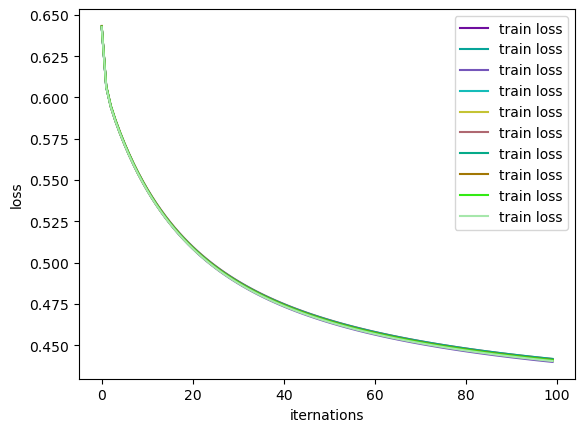

In [13]:
kf = KFold(n_splits=10)

accuracy_list = []
roc_list = []

for train_set, valid_set in kf.split(training_dataset):
    train_data = training_dataset[train_set]
    model = train(train_data)

    valid_data = training_dataset[valid_set]
    valid_data = np.concatenate([np.ones((valid_data.shape[0], 1)), valid_data], axis=1)
    y_pred = model(valid_data[:, :-2])
    roc_list.append(
        (
            roc_auc_score(valid_data[:, -2], y_pred[:, -2]),
            roc_auc_score(valid_data[:, -1], y_pred[:, -1]),
        )
    )
    # y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])
    # accuracy_list.append(accuracy(valid_data[:, -1], y_pred))

roc_list

#### 预测测试集

Shuffling data
epoch: 0, loss: 0.6396433771141468
Shuffling data
epoch: 1, loss: 0.6034927590752895
Shuffling data
epoch: 2, loss: 0.5915072553368954
Shuffling data
epoch: 3, loss: 0.5825092395396158
Shuffling data
epoch: 4, loss: 0.5745025978900917
Shuffling data
epoch: 5, loss: 0.5671532964747876
Shuffling data
epoch: 6, loss: 0.560391856381093
Shuffling data
epoch: 7, loss: 0.5541300686757162
Shuffling data
epoch: 8, loss: 0.5483362515003292
Shuffling data
epoch: 9, loss: 0.5429537496834276
Shuffling data
epoch: 10, loss: 0.5379432670519564
Shuffling data
epoch: 11, loss: 0.5332873476058212
Shuffling data
epoch: 12, loss: 0.5289256438451502
Shuffling data
epoch: 13, loss: 0.5248490725835864
Shuffling data
epoch: 14, loss: 0.5210318271107213
Shuffling data
epoch: 15, loss: 0.517438918677814
Shuffling data
epoch: 16, loss: 0.5140687134385166
Shuffling data
epoch: 17, loss: 0.5108913558567666
Shuffling data
epoch: 18, loss: 0.5078948959614957
Shuffling data
epoch: 19, loss: 0.505063278

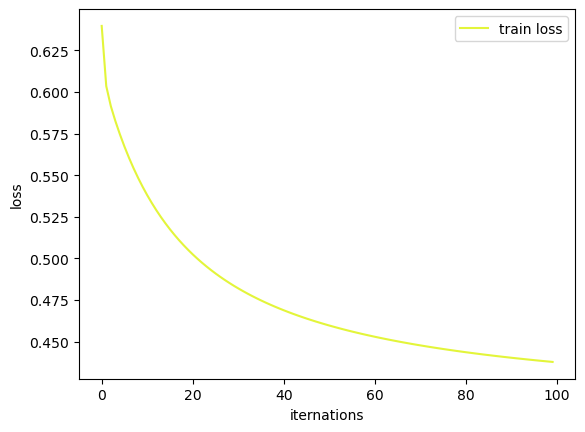

In [14]:
test_dataset = pd.read_csv(
    "../Flu Shot Learning Predict H1N1 and Seasonal Flu Vaccines/fixed_test_set.csv"
)

id_start = test_dataset["respondent_id"][0]

for id, item in enumerate(test_dataset["respondent_id"]):
    assert id + id_start == item

test_dataset = test_dataset.drop(columns=["respondent_id"])
test_dataset = np.array(test_dataset, dtype=np.float64)

model = train(training_dataset)
test_dataset = np.concatenate(
    [np.ones((test_dataset.shape[0], 1)), test_dataset], axis=1
)

y_pred = model(test_dataset)
y_pred = pd.DataFrame(
    {
        "respondent_id": np.arange(id_start, id_start + y_pred.shape[0]),
        "h1n1_vaccine": y_pred[:, -2],
        "seasonal_vaccine": y_pred[:, -1],
    }
)
y_pred.to_csv("submission.csv", index=False)